In [1]:
### Install necessary dependency
!pip install jedi
!pip install setuptools==65.6 "wheel<0.40.0"
!pip install swig
!apt-get install -y Xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install wandb
!pip install ale-py
!pip install gym==0.21.0
!pip install gym[atari]==0.21.0
!pip install autorom[accept-rom-license]==0.6.1
!pip install AutoROM==0.6.1
!AutoROM --accept-license
!pip install gym[atari,accept-rom-license]==0.21.0

  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Attempting uninstall: autorom
    Found existing installation: AutoROM 0.4.2
    Uninstalling AutoROM-0.4.2:
      Successfully uninstalled AutoROM-0.4.2
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
  Using cached AutoROM-0.4.2-py3-none-any.whl (16 kB)
  Attempting uninstall: autorom
    Found existing installation: AutoROM 0.6.1
    Uninstalling AutoROM-0.6.1:
      Successfully uninstalled AutoROM-0.6.1


In [16]:
### Import required libraries

# Mainly for openai gym wrappers and env
import numpy as np
from collections import deque
import gym
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)
from ale_py import ALEInterface
from ale_py.roms import Breakout
from collections import namedtuple
import random

# Mainly for CNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Used throughout the code
import copy
from collections import namedtuple
from itertools import count
import math
import random
import numpy as np
import time
import gym
import matplotlib.pyplot as plt
import wandb
import os


## OpenAI Gym Atari wrappers

### OpenAI Gym environments, specifically designed for Atari 2600 games. The wrappers are important to downsample the data and reduce the computation requirement especially for CNN model part. Here's a brief overview of the preprocessing functions:

**NoopResetEnv**: Introduces a random number of no-op (no-operation) steps at the beginning of each episode, where no actions are taken. This helps in diversifying initial states.

**FireResetEnv**: Takes a 'FIRE' action upon reset for environments where firing is required to start the game. It ensures that the environment is in a consistent state by taking 'FIRE' actions until the game begins.

**EpisodicLifeEnv**: Treats the end of life as the end of an episode, resetting the environment only on a true game over. This is done to align with the DQN approach, enhancing the value estimation.

**MaxAndSkipEnv**: Returns only every skip-th frame, repeating the action and summing rewards over skipped frames. This helps reduce the frame rate and memory requirements.

**ClipRewardEnv**: Bins rewards into {+1, 0, -1} based on their sign, simplifying the reward signal for the learning algorithm.

**WarpFrame**: Resizes frames to 84x84, converts to grayscale if specified, and follows the preprocessing configs used by Google Deepmind. It also allows for handling dictionary observations.

**FrameStack**: Stacks the last k frames to provide the network with temporal information. It uses a deque to efficiently manage memory.

**ScaledFloatFrame**: Normalizes pixel values to the range [0, 1], converting observations to float32.

**LazyFrames**: A memory-efficient container that stores common frames only once, optimizing memory usage for DQN's replay buffers.

--------
#### Function
**[create_atari_env]** function applies these wrappers in a specific order to create a preprocessed Atari environment with optional features like episodic life, frame stacking, scaling, and reward clipping.

**[Recorder]** function take the environment as input, test the pretrained model in that environment and capture the rendering as video in .mp4 format.

In [2]:
### OpenAI Gym Atari wrappers

## Source: https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]

def create_atari_env(env_id, episode_life=False, frame_stack=True, scale=True, clip_rewards=False):
    env = gym.make(env_id)
    # Check the Environment
    print(env.action_space.n)
    print(env.unwrapped.get_action_meanings())
    print(env.observation_space.shape)
    #observation = env.reset()
    #plt.imshow(observation)

    if 'NoFrameskip' in env_id:
        print("NoopResetEnv and MaxAndSkipEnv - from wrappers")
        assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        print("Fire - from wrappers")
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

In [34]:
### Video Recording utility function
class Recorder(gym.Wrapper):
    def __init__(self, env, directory, auto_release=True, size=None, fps=None, rgb=True):
        super(Recorder, self).__init__(env)
        self.directory = directory
        self.auto_release = auto_release
        self.active = True
        self.rgb = rgb

        # Make Directory if Not Exists
        if not os.path.exists(self.directory):
            os.mkdir(self.directory)

        # Render Size in RGB Array
        if size is None:
            self.env.reset()
            self.size = self.env.render(mode = 'rgb_array').shape[:2][::-1]
        else:
            self.size = size

        # Set Frame Rate Per Second of Video
        if fps is None:
            if 'video.frames_per_second' in self.env.metadata:
                self.fps = self.env.metadata['video.frames_per_second']
            else:
                self.fps = 10
        else:
            self.fps = fps

    # Video Function
    def pause(self):
        self.active = False

    def resume(self):
        self.active = True

    def _start(self):
        self.cliptime = time.time()
        self.path = f'{self.directory}/{self.cliptime}.mp4'
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        self._writer = cv2.VideoWriter(self.path, fourcc, self.fps, self.size)

    def _write(self):
        if self.active:
            frame = self.env.render(mode = 'rgb_array')
            if self.rgb:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            self._writer.write(frame)

    def release(self):
        self._writer.release()


    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        self._start()
        self._write()
        return observation

    def step(self, *args, **kwargs):
        data = self.env.step(*args, **kwargs)
        self._write()

        if self.auto_release and data[2]:
            self.release()

        return data

    def play(self):
        start = time.time()
        filename = 'temp-{start}.mp4'
        clip = VideoFileClip(self.path)
        clip.write_videofile(filename,  verbose = False)
        display(Video(filename, embed = True))
        os.remove(filename)

#### Replay memory is a cyclic buffer that stores and samples experiences for training a reinforcement learning agent.

**push** method --> adds new experiences.

**sample** method --> retrieves random batches for training

In [3]:
Transition = namedtuple('Transion', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Deep Q-learning network (DQN) by (Mnih et al., 2013)
The architecture followed the pytorch framework, 
1. processing image inputs through convolutional layers
2. flattening the output
3. passing it through fully connected layers to produce Q-values for different actions.

Use of ReLU activation functions introduce non-linearity. We also applied He's weight intialization and bias initialization in the model definition process.

### Double Deep Q-Network (DDQN) by (Van Hasselt et al., 2015)
- To address overestimation issues in Q-value estimates.

The key idea behind DDQN is to decouple the action-selection process from the Q-value estimation. Specifically:

1.**Online Network (Action Selection):** This network is used to select the best action at each state based on current estimates. It is responsible for determining the action with the highest Q-value.

2.**Target Network (Q-Value Evaluation):** This network is periodically updated with the weights from the online network. It is used to evaluate the Q-values associated with the selected actions. The delayed update helps stabilize training and reduces overestimation bias.

In [4]:
### The network definition

## Define Deep Q-Learning Network
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.loss_list = []
        self.reward_list = []
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(3136, 512)
        self.head = nn.Linear(512, outputs)
        nn.init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.head(x)

### Noisy-Net (NDQN) by (Fortunato et al., 2019)
On top of deep Q-learning, the Noisy Linear layer is introduced to address the exploration-exploitation dilemma by adding noise to the network's parameters. This encourages the agent to explore alternative actions. Theoritically, the noise injection helps in exploration during training, contributing to the diversity of experiences that the agent learns from. This, in turn, can improve the stability and effectiveness of the learned policy.

In [ ]:
## Define Noisy linear layer and infuse it into DQN
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma.mul(self.weight_epsilon)
            bias   = self.bias_mu   + self.bias_sigma.mul(self.bias_epsilon)
        else:
            weight = self.weight_mu
            bias   = self.bias_mu

        return F.linear(x, weight, bias)

    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))

        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))

        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))

    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)

        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))

    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

## Define Noisy Deep Q network
class NoisyDQN(nn.Module):
    def __init__(self, h, w, action_size):
        super(NoisyDQN, self).__init__()
        self.loss_list = []
        self.reward_list = []
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.noisy1 = NoisyLinear(3136, 512)
        self.noisy2 = NoisyLinear(512, action_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.noisy1(x.view(x.size(0), -1)))
        return self.noisy2(x)

    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()

1. **select_action** function:
- The maximum Q-value action is selected (exploitation) according to 1 - epsilon probability.
- A random action is selected (exploration) according to epsilon probability.

2. **optimize_model** function:
- If the replay memory (memory) is not large enough, the function returns without optimizing the model.
- 
Transitions are sampled from the replay memory, and batch tensors are created for states, actions, rewards, and next states
- For each transition, the expected state-action values are computed based on the chosen DQN variant with DQN==1 or DoubleDQN==2.
- Huber loss is computed between the predicted state-action values and the expected values.
- Gradients are calculated and clipped to avoid exploding gradients.
- The optimizer is updated to minimize the loss.

2. **get_state** function:
- The function converts the observation to a numpy array, transposes the dimensions, and converts it to a PyTorch tensor.
- 
The resulting tensor is returned after adding an extra dimension to represent the batch size

4. **train** funcion:
- The key highlight in this function is to train the DQN and reset the environment during each episodes.
- One improvisation we made is that we log the metrics using wandb.log() api.

6. **test** function:
- One of the purpose of the function is to take pretrained model and evaluate the model with resetted environment.
- The function also process the env.render() into video as output.. lossn).

In [14]:
def select_action(state):
    global epsilon
    global steps_done
    sample = random.random()
    epsilon -= EPS_DECAY
    if epsilon <= EPS_END:
        epsilon = EPS_END
    steps_done += 1
    if sample > epsilon:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state.to(device)).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(action_num)]], device=device, dtype=torch.long)

def optimize_model(choice):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    """
    zip(*transitions) unzips the transitions into
    Transition(*) creates new named tuple
    batch.state - tuple of all the states (each state is a tensor)
    batch.next_state - tuple of all the next states (each state is a tensor)
    batch.reward - tuple of all the rewards (each reward is a float)
    batch.action - tuple of all the actions (each action is an int)
    """
    batch = Transition(*zip(*transitions))
    actions = tuple((map(lambda a: torch.tensor([[a]], device=device), batch.action)))
    rewards = tuple((map(lambda r: torch.tensor([r], device=device), batch.reward)))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)

    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(actions)
    reward_batch = torch.cat(rewards)

    state_action_values = policy_net(state_batch.to(device)).gather(1, action_batch)  # [batch_size, 1]
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    if choice == 1:
        # # DQN
        # # Yt ≡ R + γmaxQ(S, a; θ−) θ−: weights of target_net
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    elif choice == 2:
        # # DDQN
        # # Yt = Rt+1 + γQ(St+1, argmaxQ(St+1, a; θt); θt')
        next_action = policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_action).squeeze(1)

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()

def get_state(obs):
    state = np.array(obs)
    state = state.transpose((2, 0, 1))
    state = state.astype(np.float32)
    state = torch.from_numpy(state)
    return state.unsqueeze(0)

def train(env, n_episodes, render=False, choice=0):
    start_optimize = False
    loss = 0.0
    score = 0
    for episode in range(1, n_episodes + 1):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for step in count():
            action = select_action(state)
            if render:
                env.render()
            obs, reward, done, info = env.step(action)
            total_reward += reward
            if not done:
                next_state = get_state(obs)
            else:
                next_state = None
            reward = torch.tensor([reward], device=device)
            memory.push(state, action.to(device), next_state, reward.to(device))
            state = next_state
            if steps_done > INITIAL_MEMORY:
                start_optimize = True
                loss += optimize_model(choice)
                if (steps_done - INITIAL_MEMORY) % 1000 == 0:
                    policy_net.loss_list.append(loss / 1000)
                    loss = 0.0
            if steps_done % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())
            if done:
                break
        score += total_reward
        print('Episode {}/{} Step_total {} steps: {} epsilon {} Total reward: {}'.format(episode, n_episodes, steps_done, step + 1, epsilon, total_reward))
        wandb.log({"episode": episode, "steps": step + 1, "epsilon": epsilon, "total_reward": total_reward, "loss": loss, "score": score})
        if episode % 10 == 0:
            policy_net.reward_list.append(score/10)
            score = 0
        if episode % 100 == 0 and start_optimize:
            torch.save(policy_net, MODEL_PATH)
    env.close()
    return

def test(env, n_episodes, policy, path, render=True):
    #env = gym.wrappers.Monitor(env, './test_model', force=True)
    env = Recorder(env, path)
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = policy(state.to(device)).max(1)[1].view(1, 1)
            if render:
                env.render(mode="rgb_array")
            obs, reward, done, info = env.step(action)
            total_reward += reward
            if not done:
                next_state = get_state(obs)
            else:
                next_state = None
            state = next_state
            if done:
                print("Finished Episode {} with steps {} reward {}".format(episode + 1, t + 1, total_reward))
                break
    env.close()
    return

In [7]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR = '/content/drive/My Drive/DeepReinforcementLearning'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### The OpenAI Gym Breakout environment is a classic reinforcement learning environment designed for testing and developing reinforcement learning algorithms. Breakout is an arcade game that was released by Atari in 1976. The goal of the game is to break a wall of bricks using a ball that bounces off a paddle controlled by the player. The game provides a challenging environment for reinforcement learning agents due to its dynamic nature and the need for precise control.

#### Action Space:
- Type: Discrete
- Size: 4
- The agent can take one of the four actions including doing nothing, firing the ball to start the game, moving the paddle to right, moving the paddle to left.

#### Observation Space:
- Type: Box (2D numpy array)
- Shape: (210, 160, 3)
- The environment provides RGB images of the game screen as observations. Each observation is a 3D array of shape (210, 160, 3) representing the pixel values of the game scre

#### Preprocessed Breakout
- Type: Box (2D numpy array)
- Shape: (84, 84, 4)
- The final pixel dimensions of the breakout environement will be grayscaled and normalized 84x84 pixels and the final prediction by the DQN is 4 corresponding to four possible actions of agent can take.en.

4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)


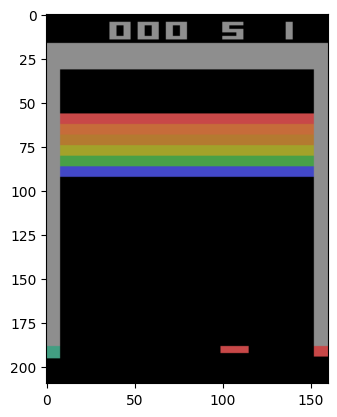

In [10]:
# RGB version of Breakout Atari
env = gym.make("ALE/Breakout-v5")
# Check the Environment
print(env.action_space.n)
print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)
observation = env.reset()
plt.imshow(observation)

4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers


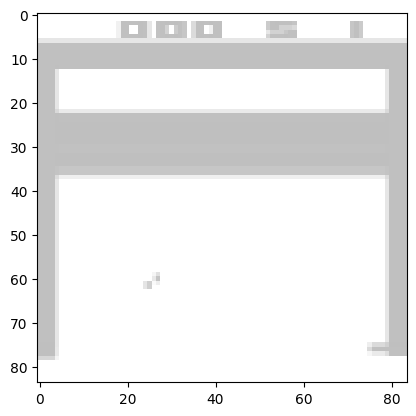

In [11]:
# Preprocessed version of Breakout Atari
env = create_atari_env("ALE/Breakout-v5")
observation = env.reset()
plt.imshow(observation)

## Experiments
1. Using DQN
2. Using Double DQN
3. Using Noisy DQN
4. Using Noisy Double DQN

- Each of the models will be trained and tested usng the constant hyperparameters for comparisons.

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# universal hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EXPLORE_STEP = 100000
EPS_DECAY = (EPS_START - EPS_END) / EXPLORE_STEP
TARGET_UPDATE = 1000
RENDER = False
lr = 1e-5
MEMORY_SIZE = 10000
INITIAL_MEMORY = 20000
NUM_EPISODES = 5000
HEIGHT = 84
WIDTH = 84
TEST_EPISODES = 10

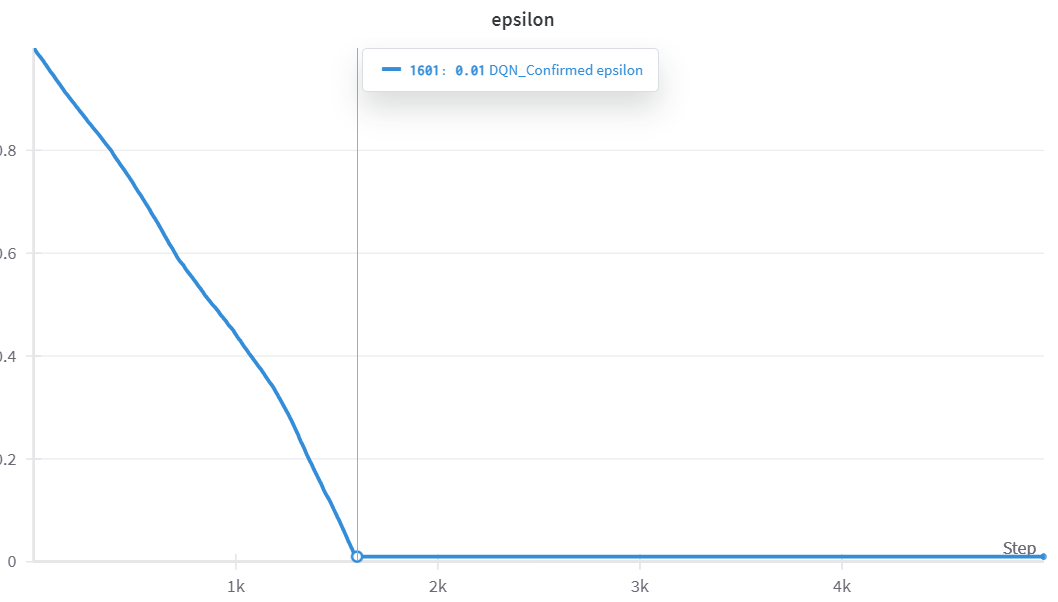

The graph show the decay of epsilon along the training of episodes of each agents. We planned the epsilon to have approximately 15% of the episodes for the agent for exploration meaning the 15% of the episodes will have epsilon > 0.01. The last 85% of the episodes will strictly require agent to exploit the environment.

--------
## DQN Training and evaluation

In [ ]:
### training and Testing DQN
MODEL_PATH = 'dqn_model_scale.pt'

# create environment
env = create_atari_env("ALE/Breakout-v5", episode_life=False, frame_stack=True, scale=True, clip_rewards=True)
epsilon = EPS_START
steps_done = 0
# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)

# create networks
action_num = env.action_space.n
policy_net = DQN(HEIGHT, WIDTH, action_num).to(device)
target_net = DQN(HEIGHT, WIDTH, action_num).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
print(policy_net)

# setup optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=lr)

# train model
wandb.init(project="DQN_Training")
wandb.watch(policy_net)
train(env, NUM_EPISODES, choice=1)
torch.save(policy_net, MODEL_PATH)

# test the model
policy_net = torch.load(MODEL_PATH)
test(env, TEST_EPISODES, policy_net, render=False)

cpu
4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers
DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc4): Linear(in_features=3136, out_features=512, bias=True)
  (head): Linear(in_features=512, out_features=4, bias=True)
)


wandb: Currently logged in as: langk1026. Use `wandb login --relogin` to force relogin


Streaming output truncated to the last 5000 lines.
Episode 11/5000 Step_total 569 steps: 58 epsilon 0.994366899999996 Total reward: 1.0
Episode 12/5000 Step_total 636 steps: 67 epsilon 0.9937035999999955 Total reward: 2.0
Episode 13/5000 Step_total 705 steps: 69 epsilon 0.993020499999995 Total reward: 3.0
Episode 14/5000 Step_total 802 steps: 97 epsilon 0.9920601999999943 Total reward: 5.0
Episode 15/5000 Step_total 845 steps: 43 epsilon 0.991634499999994 Total reward: 1.0
Episode 16/5000 Step_total 892 steps: 47 epsilon 0.9911691999999936 Total reward: 0.0
Episode 17/5000 Step_total 944 steps: 52 epsilon 0.9906543999999933 Total reward: 1.0
Episode 18/5000 Step_total 1037 steps: 93 epsilon 0.9897336999999926 Total reward: 6.0
Episode 19/5000 Step_total 1089 steps: 52 epsilon 0.9892188999999922 Total reward: 2.0
Episode 20/5000 Step_total 1127 steps: 38 epsilon 0.988842699999992 Total reward: 1.0
Episode 21/5000 Step_total 1172 steps: 45 epsilon 0.9883971999999916 Total reward: 1.0
Epi

In [45]:
# load pretrained model and record video of env.render()
MODEL_PATH = r"dqn_model_scale.pt"
device = torch.device("cpu")
env = create_atari_env("ALE/Breakout-v5", episode_life=False, frame_stack=True, scale=True, clip_rewards=True)
policy_net = torch.load(MODEL_PATH)
test(env, 1, policy_net, "dqn_video", render=True)

4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers
Finished Episode 1 with steps 149 reward 12.0


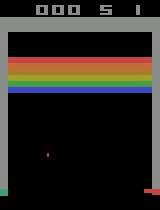

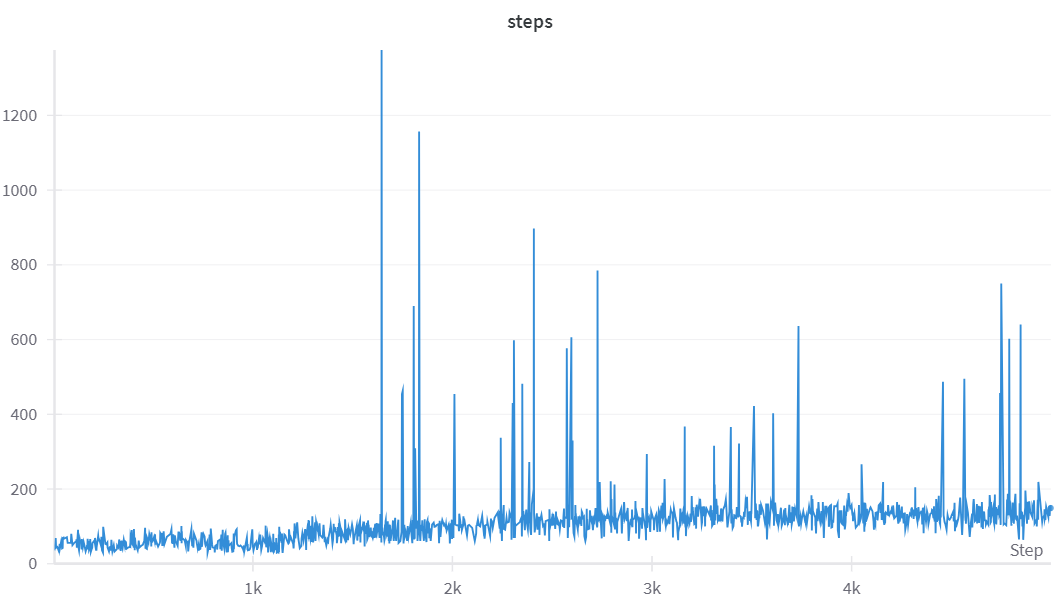

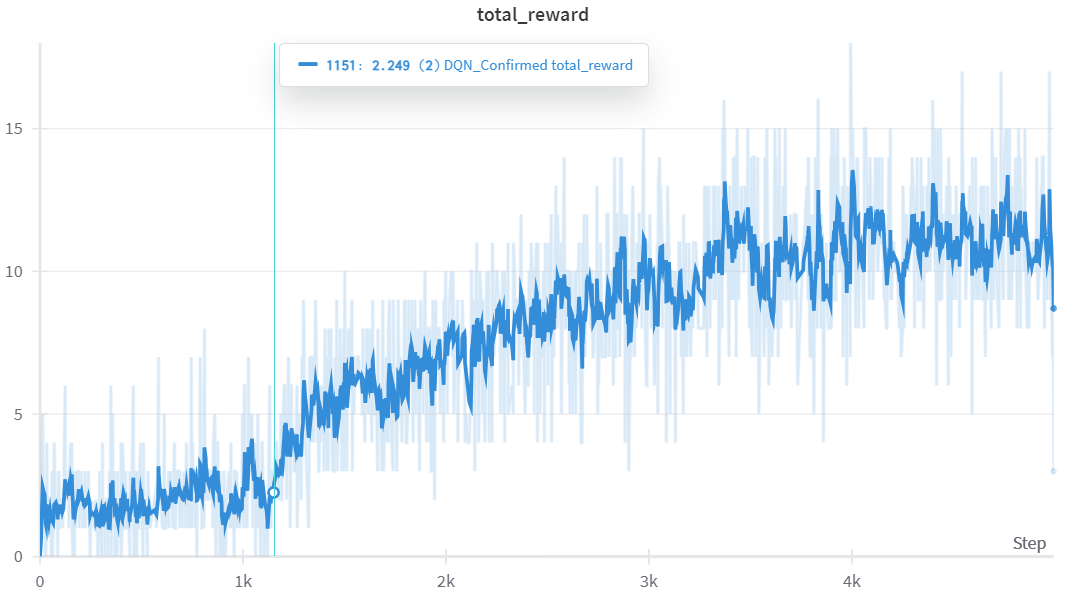

### Based on the reward graph and epsilon graph we can deduce 2 important findings.
1. The mean reward trend was steadily increasing indicating the learning process of the DQN agent was correct but based on the gradient of the graph, the learning of agent was not quick enough.
2. The change in epsilon value throughout the episodes have changed the learning nature of the DQN agent we can see at the cut off point around 1100++ epoch, the DQN agent forced to stop exploring and start exploiting the environment.

* The graph was preprocessed with smoothing scale of 0.6 for better visualization.

--------
## DDQN Training and evaluation

In [9]:
### Training and Testing DDQN
MODEL_PATH = 'ddqn_model_scale.pt'

# create environment
env = create_atari_env("ALE/Breakout-v5", episode_life=False, frame_stack=True, scale=True, clip_rewards=False)
epsilon = EPS_START
steps_done = 0
# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)

# create networks
action_num = env.action_space.n
policy_net = DQN(HEIGHT, WIDTH, action_num).to(device)
target_net = DQN(HEIGHT, WIDTH, action_num).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
print(policy_net)

# setup optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=lr)

# train model
wandb.init(project="DDQN_Training")
wandb.watch(policy_net)
train(env, NUM_EPISODES, choice=2)
torch.save(policy_net, MODEL_PATH)

# Test the model
policy_net = torch.load(MODEL_PATH)
test(env, TEST_EPISODES, policy_net, render=False)

cpu
4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers
DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc4): Linear(in_features=3136, out_features=512, bias=True)
  (head): Linear(in_features=512, out_features=4, bias=True)
)


wandb: Currently logged in as: langk1026. Use `wandb login --relogin` to force relogin


Streaming output truncated to the last 5000 lines.
Episode 11/5000 Step_total 638 steps: 55 epsilon 0.9936837999999955 Total reward: 1.0
Episode 12/5000 Step_total 682 steps: 44 epsilon 0.9932481999999951 Total reward: 0.0
Episode 13/5000 Step_total 736 steps: 54 epsilon 0.9927135999999948 Total reward: 1.0
Episode 14/5000 Step_total 776 steps: 40 epsilon 0.9923175999999945 Total reward: 0.0
Episode 15/5000 Step_total 820 steps: 44 epsilon 0.9918819999999942 Total reward: 1.0
Episode 16/5000 Step_total 884 steps: 64 epsilon 0.9912483999999937 Total reward: 3.0
Episode 17/5000 Step_total 944 steps: 60 epsilon 0.9906543999999933 Total reward: 2.0
Episode 18/5000 Step_total 985 steps: 41 epsilon 0.990248499999993 Total reward: 1.0
Episode 19/5000 Step_total 1028 steps: 43 epsilon 0.9898227999999927 Total reward: 0.0
Episode 20/5000 Step_total 1091 steps: 63 epsilon 0.9891990999999922 Total reward: 2.0
Episode 21/5000 Step_total 1166 steps: 75 epsilon 0.9884565999999917 Total reward: 3.0
E

In [42]:
# # load pretrained model and record video of env.render()
env = create_atari_env("ALE/Breakout-v5", episode_life=False, frame_stack=True, scale=True, clip_rewards=False)
MODEL_PATH = r"ddqn_model_scale.pt"
policy_net = torch.load(MODEL_PATH)
test(env, 1, policy_net, "ddqn_video", render=True)

4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers
Finished Episode 1 with steps 177 reward 22.0


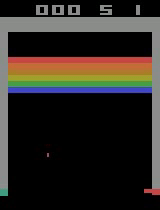

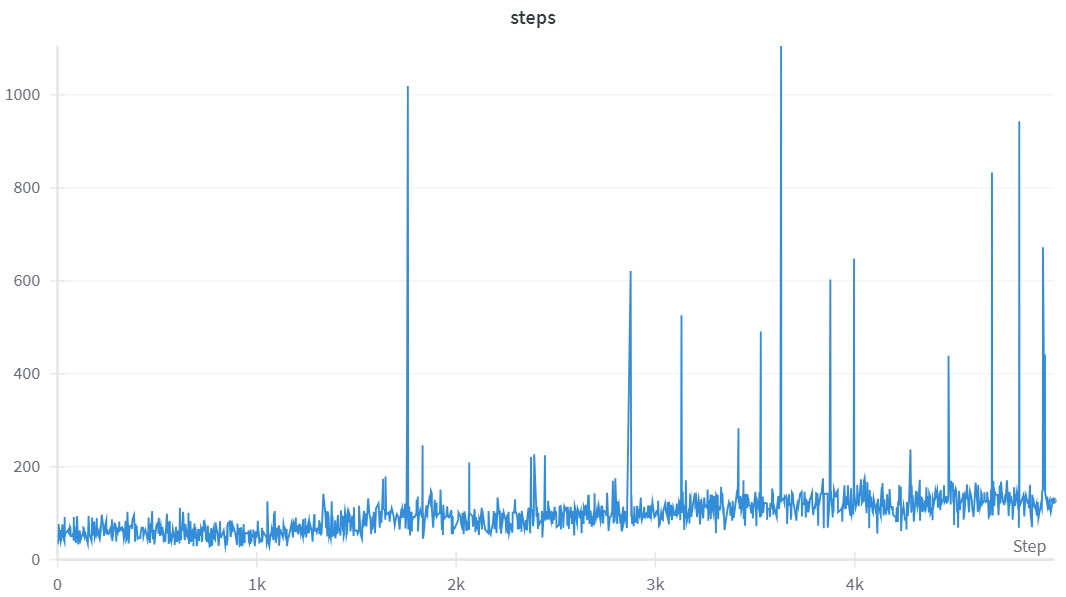

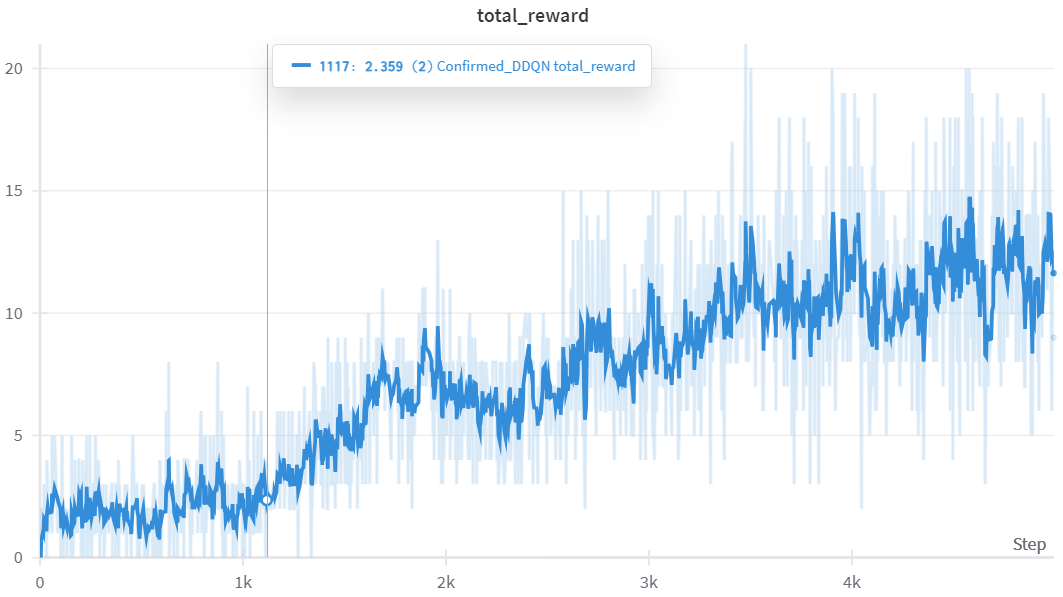
By analysing the reward graph, the DDQN agent 3 important findings
1. The epsilon exploration-exploitation switch at episode around 1100++ which required the agent to maximize the reward and winning more points. 
2. The DDQN agent learning to maximize the reward steadily but slowly to the global optimal in the correct path.
3. The DDQN agent learning ability was marginly better than DQN agent because we saw that the overall rewards obtained by DDQN agent around episode 4000 were higher than DQN agent.

* The graph was preprocessed with smoothing scale of 0.6 for better visualization.

--------
## NDQN Training and evaluation

In [ ]:
### Training and Testing NDQN
MODEL_PATH = 'noisy_dqn_model_scale.pt'

# create environment
env = create_atari_env("ALE/Breakout-v5", episode_life=False, frame_stack=True, scale=True, clip_rewards=False)
epsilon = EPS_START
steps_done = 0
# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)

# create networks
action_num = env.action_space.n
policy_net = NoisyDQN(HEIGHT, WIDTH, action_num).to(device)
target_net = NoisyDQN(HEIGHT, WIDTH, action_num).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
print(policy_net)

# setup optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=lr)

# train model
wandb.init(project="Noisy_DQN_Training")
wandb.watch(policy_net)
train(env, NUM_EPISODES, choice=3)
torch.save(policy_net, MODEL_PATH)

# load GPU model on GPU
C:\Users\langk\Downloads
policy_net = torch.load(MODEL_PATH)
test(env, TEST_EPISODES, policy_net, render=False)

cpu
4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers
NoisyDQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (noisy1): NoisyLinear()
  (noisy2): NoisyLinear()
)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Streaming output truncated to the last 5000 lines.
Episode 11/5000 Step_total 593 steps: 53 epsilon 0.9941292999999958 Total reward: 2.0
Episode 12/5000 Step_total 657 steps: 64 epsilon 0.9934956999999953 Total reward: 3.0
Episode 13/5000 Step_total 738 steps: 81 epsilon 0.9926937999999947 Total reward: 3.0
Episode 14/5000 Step_total 796 steps: 58 epsilon 0.9921195999999943 Total reward: 2.0
Episode 15/5000 Step_total 843 steps: 47 epsilon 0.991654299999994 Total reward: 2.0
Episode 16/5000 Step_total 891 steps: 48 epsilon 0.9911790999999937 Total reward: 0.0
Episode 17/5000 Step_total 928 steps: 37 epsilon 0.9908127999999934 Total reward: 0.0
Episode 18/5000 Step_total 980 steps: 52 epsilon 0.990297999999993 Total reward: 2.0
Episode 19/5000 Step_total 1023 steps: 43 epsilon 0.9898722999999927 Total reward: 0.0
Episode 20/5000 Step_total 1087 steps: 64 epsilon 0.9892386999999923 Total reward: 2.0
Episode 21/5000 Step_total 1136 steps: 49 epsilon 0.9887535999999919 Total reward: 1.0
Ep

In [37]:
# load pretrained model and record video of env.render()
env = create_atari_env("ALE/Breakout-v5", episode_life=False, frame_stack=True, scale=True, clip_rewards=False)
MODEL_PATH = r"ndqn_model_scale.pt"
policy_net = torch.load(MODEL_PATH)
test(env, 1, policy_net, "ndqn_video", render=True)

4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers
Finished Episode 1 with steps 55 reward 2.0


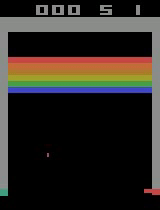

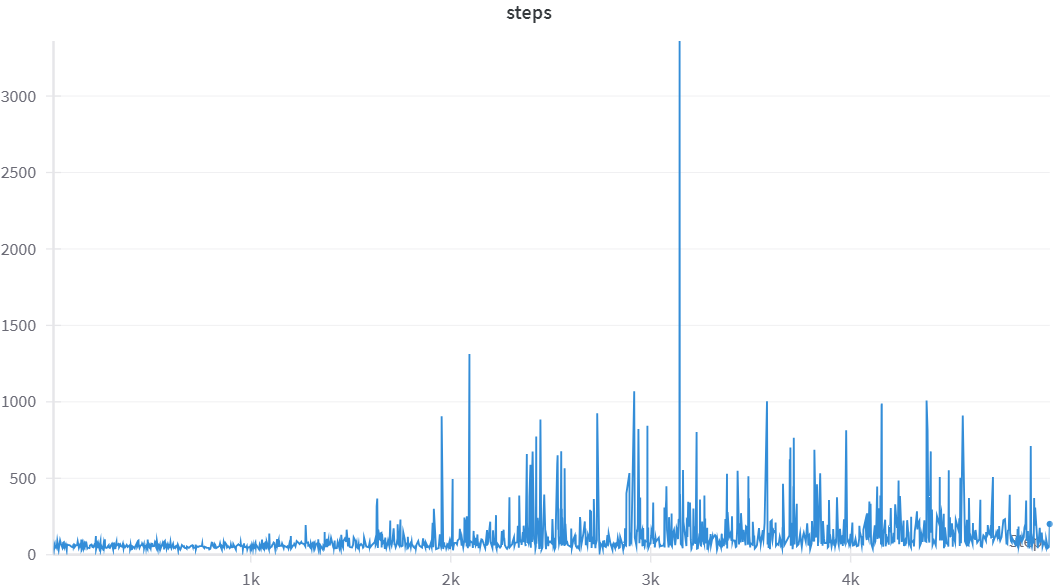

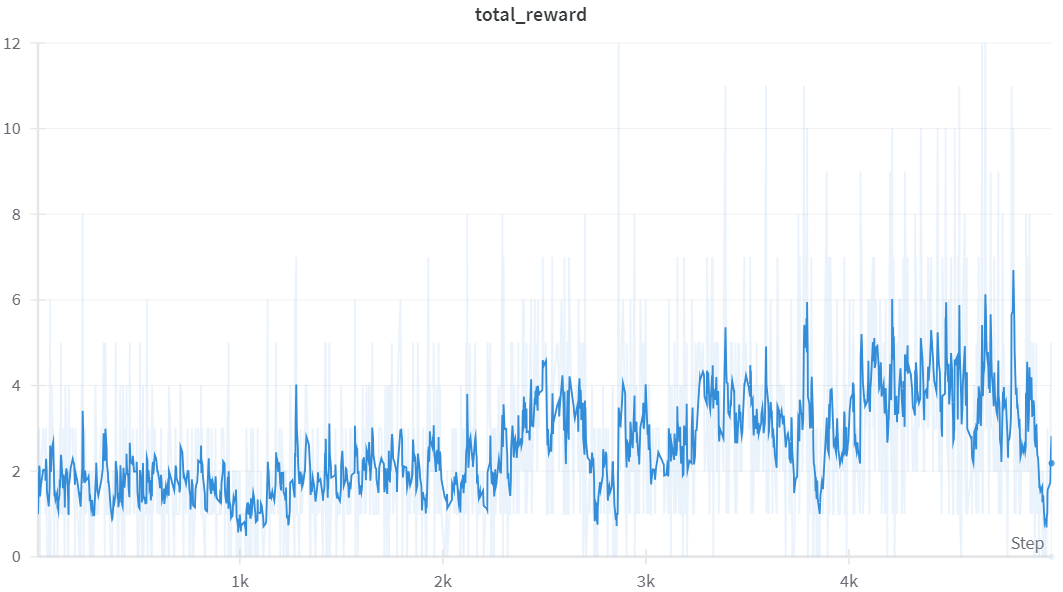
Few deductions can be found on this reward graph: 
1. The reward obtained by NDQN agent fluctuates greatly, which makes the analysis more difficult. This means that the NDQN agent struggle to learn the breakout environment. 
2. The stepsize graph suggest the abnormality of the NDQN agent as the step size was very unusually higher than average stepsize. The problem can be orgininate from the code implementation.

* The reward graph was preprocessed with smoothing scale of 0.6 for better visualization.

--------
## NDDQN Training and evaluation

In [ ]:
### Training and Testing NDDQN
MODEL_PATH = 'nddqn_model_scale.pt'

# create environment
env = create_atari_env("ALE/Breakout-v5", episode_life=False, frame_stack=True, scale=True, clip_rewards=False)
epsilon = EPS_START
steps_done = 0
# initialize replay memory
memory = ReplayMemory(MEMORY_SIZE)

# create networks
action_num = env.action_space.n
policy_net = NoisyDQN(HEIGHT, WIDTH, action_num).to(device)
target_net = NoisyDQN(HEIGHT, WIDTH, action_num).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
print(policy_net)

# setup optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=lr)

# train model
wandb.init(project="NDDQN_Training")
wandb.watch(policy_net)
train(env, NUM_EPISODES, choice=2)
torch.save(policy_net, MODEL_PATH)

# load GPU model on GPU
policy_net = torch.load(MODEL_PATH)
test(env, TEST_EPISODES, policy_net, render=False)

cpu
4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers
NoisyDQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (noisy1): NoisyLinear()
  (noisy2): NoisyLinear()
)


wandb: Currently logged in as: langk1026. Use `wandb login --relogin` to force relogin


Streaming output truncated to the last 5000 lines.
Episode 11/5000 Step_total 600 steps: 47 epsilon 0.9940599999999957 Total reward: 0.0
Episode 12/5000 Step_total 648 steps: 48 epsilon 0.9935847999999954 Total reward: 1.0
Episode 13/5000 Step_total 713 steps: 65 epsilon 0.9929412999999949 Total reward: 3.0
Episode 14/5000 Step_total 760 steps: 47 epsilon 0.9924759999999946 Total reward: 2.0
Episode 15/5000 Step_total 846 steps: 86 epsilon 0.991624599999994 Total reward: 4.0
Episode 16/5000 Step_total 919 steps: 73 epsilon 0.9909018999999935 Total reward: 3.0
Episode 17/5000 Step_total 961 steps: 42 epsilon 0.9904860999999932 Total reward: 0.0
Episode 18/5000 Step_total 1041 steps: 80 epsilon 0.9896940999999926 Total reward: 4.0
Episode 19/5000 Step_total 1109 steps: 68 epsilon 0.9890208999999921 Total reward: 3.0
Episode 20/5000 Step_total 1178 steps: 69 epsilon 0.9883377999999916 Total reward: 1.0
Episode 21/5000 Step_total 1243 steps: 65 epsilon 0.9876942999999911 Total reward: 3.0


In [47]:
# load pretrained model and record video of env.render()
env = create_atari_env("ALE/Breakout-v5", episode_life=False, frame_stack=True, scale=True, clip_rewards=False)
MODEL_PATH = r"nddqn_model_scale.pt"
policy_net = torch.load(MODEL_PATH)
test(env, 1, policy_net, "nddqn_video", render=True)

4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
Fire - from wrappers
Finished Episode 1 with steps 6748 reward 2.0


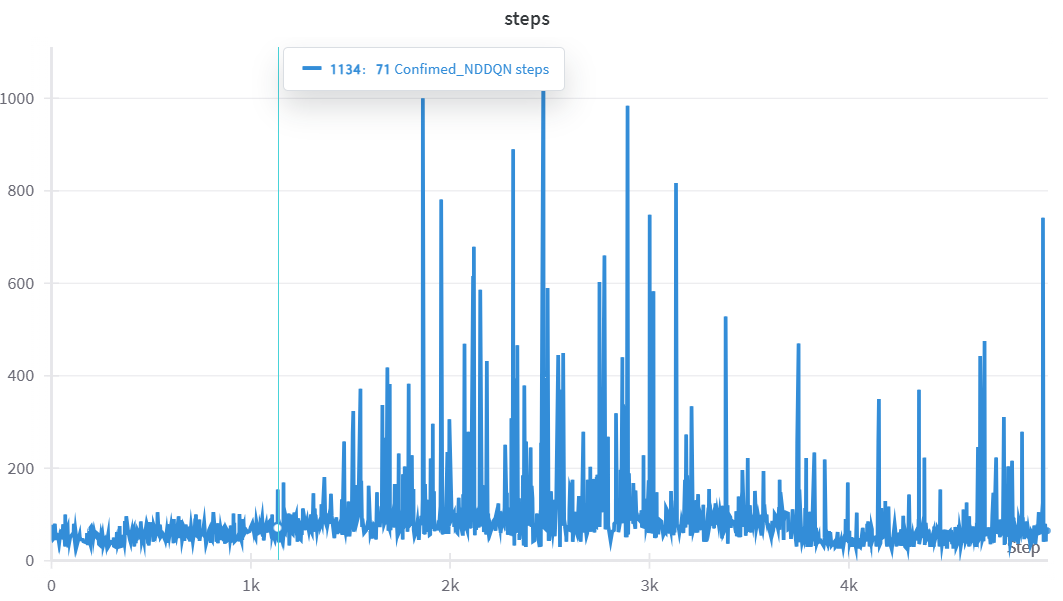

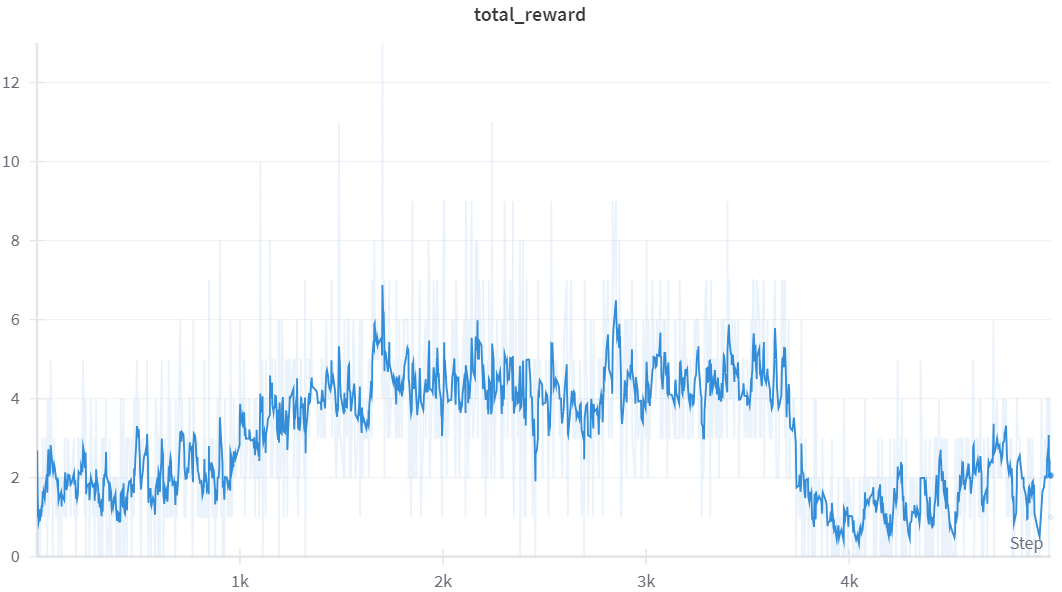
Few analysis can be made from the graphs: 
1. Even though the epsilon exploration-exploitation switch cannot be precisely detemined in reward graph, but we saw that the steps made by the NDDQN agent increases significant starting at 1100 episode due to epsilon decay.
2. The reward gained by the NDDQN agent was fine in the intial half of the training, but, the NDDQN agent was confused at the later stage causing the trend of the reward graph declined.

* The reward graph was preprocessed with smoothing scale of 0.6 for better visualization.

## Conclusion and thoughts:

1. Overall, DQN and DDQN agents performed as we expected but still relatively slow. This problem can be due to we missed the optimal hyperparameter to feed in the models. However, the hyperparameter tuning in deep reinforcement learning was extremely expensive as we spent 24 hours on Google Colab to train one whole project for one set of hyperparameters.

2. The NDQN and NNDQN agents does not performed as we expected especially the NDDQN was the rarely experimented by the researchers. This problem was due to insufficient knowledge on the whole noisy architecture, we were not sure that the implementation of NDQN and NDDQN were 100% correct. Besides, the alpha and beta hyperparameter was also not yet tuned. 

3. The average step size of each agents that we had trained was around 5x10e5 which was extremely lower han the work done by Google Deepmind and the top researchers. We know that, by this amount of step size, the agent was starting to learning something but we forced to interupt it due to time and machine limitations. We believed that, given more stepsize our DDQN or DQN agent can achieve higher reward around 100++. 

4. We think there is importance of episodelife feature in the environment which means that the agent's number of life remaining to play the game. The reward function probably can be further clipped so the agent will not completely neglect the episodelife. Even though, some of the articles suggested no large implications in this subject.  

4. The realization regarding the training in google colab using cpu was extremely slower than using PC cpu. 

## Reference
- Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. (2013, December 19). Playing Atari with deep reinforcement learning. arXiv.org. https://arxiv.org/abs/1312.5602 
- Van Hasselt, H., Guez, A., & Silver, D. (2015, December 8). Deep reinforcement learning with double Q-learning. arXiv.org. https://arxiv.org/abs/1509.06461 
- Fortunato, M., Azar, M. G., Piot, B., Menick, J., Osband, I., Graves, A., Mnih, V., Munos, R., Hassabis, D., Pietquin, O., Blundell, C., & Legg, S. (2019, July 9). Noisy Networks for Exploration. arXiv.org. https://arxiv.org/abs/1706.10295 